# Fashion Item Identification using PCA & SVM
*Tim Hargreaves*

Heavy inspired by [Frank C](https://www.kaggle.com/cnjn22)'s [Digit Recogniser](https://www.kaggle.com/cnjn22/digit-recognizer) kernel

## Contents
*  Loading and Checking Data
* Data Preprocessing
* PCA on Data
* Train and Predict
* Evaluation

## Loading and Checking Data
We will start by loading any packages we will require for our analysis.

In [1]:
library(readr)
library(caret)

Loading required package: lattice
Loading required package: ggplot2


We can now load the training and testing data.

In [2]:
train <- read_csv("../input/fashion-mnist_train.csv")
train <- train[1:1000,]
test <- read_csv("../input/fashion-mnist_test.csv")
label.names <- c("T-shirt/top",
                 "Trouser",
                 "Pullover",
                 "Dress",
                 "Coat",
                 "Sandal",
                 "Shirt",
                 "Sneaker",
                 "Bag",
                 "Ankle boot") 

Parsed with column specification:
cols(
  .default = col_double()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_double()
)
See spec(...) for full column specifications.


Let's have a look at the structure of the data.

In [3]:
dimMtrx <- rbind(dim(train), dim(test))
rownames(dimMtrx) <- c("Train", "Test")
colnames(dimMtrx) <- c("Rows", "Cols")
print(dimMtrx)

label.factor <- as.factor(train$label)
levels(label.factor) <- label.names
table(label.factor)

       Rows Cols
Train  1000  785
Test  10000  785


label.factor
T-shirt/top     Trouser    Pullover       Dress        Coat      Sandal 
        108          89          99         112         114          83 
      Shirt     Sneaker         Bag  Ankle boot 
        106         102          96          91 

As we can see, each dataset has 785 columns, 1 of which is the label attriubute and the other 784 are predictors representing the pixel values of the image. The train dataset has 60000 observations and the test dataset has 10000. Lastly we can see that there is an equal number of each clothing item in the training dataset.

Since, we mere humans, have no way of interpretting what the images supplied look like from the table of pixel values alone, let's select a random sample of 10 images for each item of clothing and turn them into images.

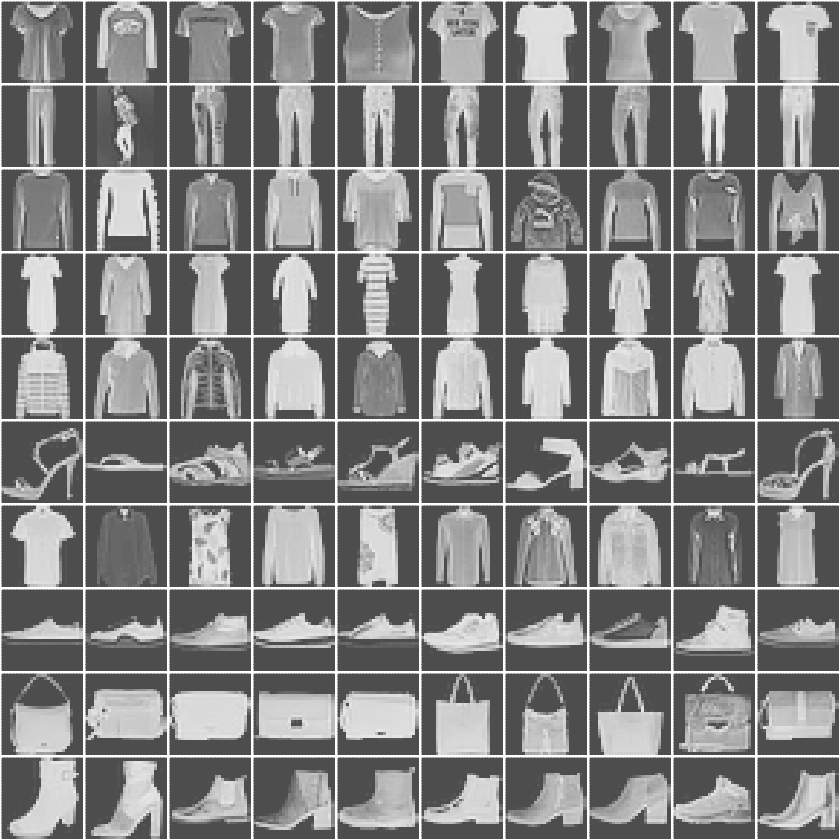

In [4]:
sample <- sapply(0:9, function(x) sample(which(train$label == x), 10))
pxlVals <- t(train[sample, -1])
pxlVals.mtrx <- lapply(1:100, function(x) matrix(pxlVals[,x], ncol = 28))
par(mfrow = c(10,10), mar = rep(.1, 4))
                       
for(i in 1:100){
    for(j in 1:28) {
    pxlVals.mtrx[[i]][j,] <- rev(pxlVals.mtrx[[i]][j,])
  }
    image(pxlVals.mtrx[[i]],col=grey.colors(225),axes=F)
}

## Data Preproccessing
Since our dataset is likely to contain some predictors that don't tell us much about which item of clothing the image is of (i.e. the corners) it is important to remove any predictors that either have a unique value or have a near zero variance.

In [5]:
nzrv <- nearZeroVar(train[,-1], saveMetrics = T, freqCut = 300, uniqueCut = 1/4)
discard <- rownames(nzrv[nzrv$nzv,])
keep <- setdiff(names(train), discard)
train <- train[,keep]

cat(sum(nzrv$nzv), "near zero variance predictors have been removed,", "\n") 
cat(sum(nzrv$zeroVar), "of which were zero variance predictors.")

2 near zero variance predictors have been removed, 
0 of which were zero variance predictors.

## PCA on Data
Since we have to many predictors, we will need to use PCA on the training dataset. We will begin by scaling the data so the values lie between 0 and 1, and then we can obtain a covariance matrix of the predictors.

In [6]:
label <- as.factor(train$label)
train$label <- NULL
train <- train / 255
train.cov <- cov(train)

We are now ready to apply PCA to the covariance matrix and then plot a graph to show how the number of components affect the varience explained so we can choose how many components to model.

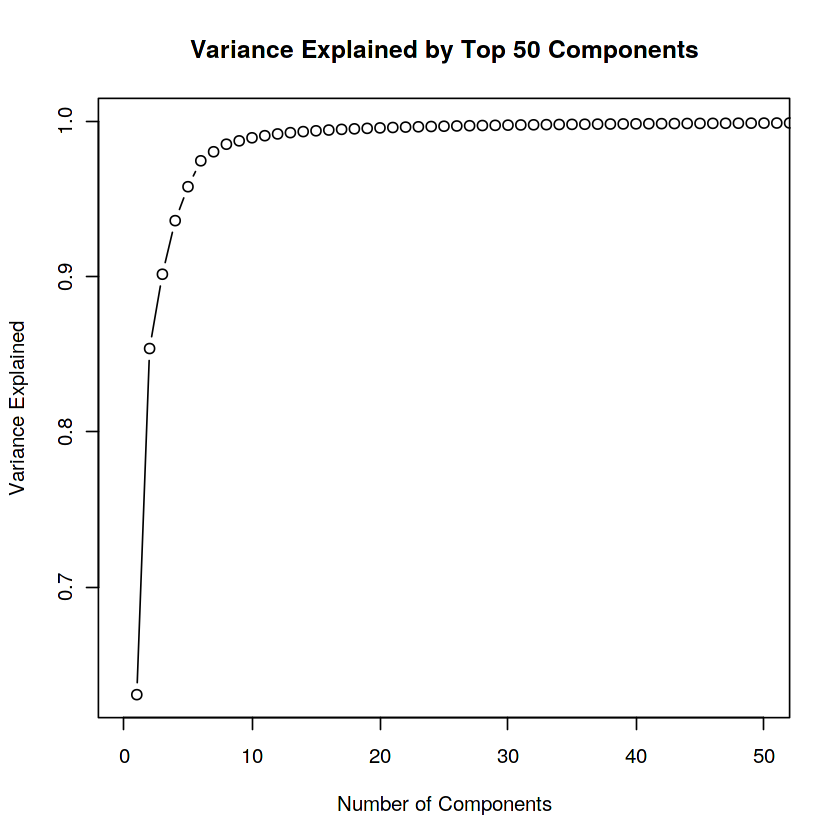

In [7]:
train.pc <- prcomp(train.cov)
var.ex <- train.pc$sdev^2 / sum(train.pc$sdev^2)
var.cum <- cumsum(var.ex)

results <- data.frame(num <- 1:length(train.pc$sdev),
                     ex = var.ex,
                     cum = var.cum)

plot(results$num, results$cum, type = "b", xlim = c(0,50),
     main = "Variance Explained by Top 50 Components",
     xlab = "Number of Components", ylab = "Variance Explained")

From the plot, we can see that 25 components would be a good choice. We can now plot the first two principal components.

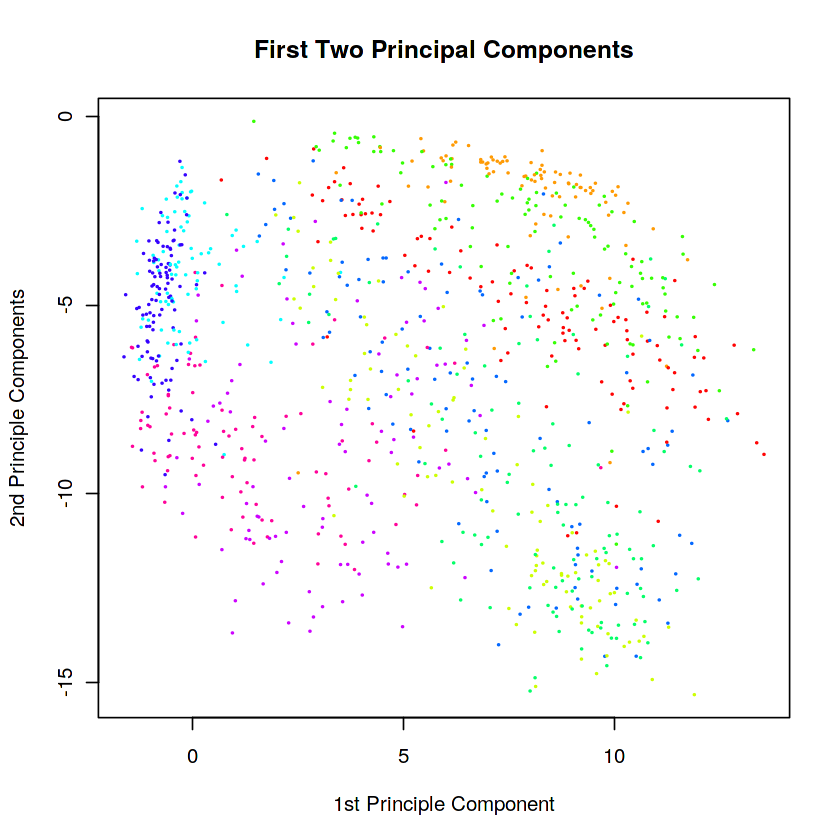

In [8]:
train.score <- as.matrix(train) %*% train.pc$rotation[,1:25]
train <- cbind(label, as.data.frame(train.score))

colours <- rainbow(length(unique(train$label)))
names(colours) <- unique(train$label)
plot(train$PC1, train$PC2, type = "p", main = "First Two Principal Components",
     col = colours[train$label], cex = 0.1, xlab = "1st Principle Component",
     ylab = "2nd Principle Components")

## Train and Predict
Finally we're at a point where we are ready to produce a model and then let it loose on our test data. We will be using the SVM classification algorthm for this, in particular the Radial Basis Function kernel. After creating the model we can proces our testing data as we did the training data and the use our model to predict the item of clothing that each image is of.

In [9]:
svm_mdl <- train(label~.,data=train,
                 method="svmRadial",
                 trControl=trainControl(method="cv", number=5),
                 tuneGrid=data.frame(sigma = 0.01104614, C = 3.5))
print(svm_mdl)

Support Vector Machines with Radial Basis Function Kernel 

1000 samples
  25 predictor
  10 classes: '0', '1', '2', '3', '4', '5', '6', '7', '8', '9' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 800, 799, 800, 802, 799 
Resampling results:

  Accuracy   Kappa    
  0.7849732  0.7607391

Tuning parameter 'sigma' was held constant at a value of 0.01104614

Tuning parameter 'C' was held constant at a value of 3.5


In [10]:
test.labels <- test[,1]
test <- test[,keep[-1]]/255
test <- as.matrix(test) %*% train.pc$rotation[,1:25]
test <- as.data.frame(test)

In [18]:
pred <- predict(svm_mdl$finalModel, test, type = "response")
test$prediction <- pred

ERROR: Error in UseMethod("predict"): no applicable method for 'predict' applied to an object of class "c('ksvm', 'vm')"


## Evaluation
We can now evaluate the quality of our model and find its shortcomings. First we will print a table to see how the model predictions and the actual labels compare and then use this to find out model accuracy.

In [ ]:
tbl <- table(test.labels, test$prediction)
print(tbl)
cat("The model is ", 100 * sum(diag(tbl)) / nrow(test), "% accurate.", sep = "")